# Демонстрация финализации и калибровки модели

In [1]:
# расширяем поле, убираем предупреждения
from IPython.core.display import display, HTML
display(HTML('<style>.container {width:95% !important;}</style>'))

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Стандартные библиотеки для анализа
import pandas as pd
pd.options.display.float_format = '{:20,.2f}'.format

from sklearn.model_selection import train_test_split, StratifiedKFold

import catboost as catb # CatBoostClassifier, CatBoostRegressor

import matplotlib.pylab as pl

In [3]:
import sys
sys.path.append('../')

# Наша разработанная библиотека
from autobinary import SentColumns, CatBoostEncoder, AutoTrees, base_pipe, FinalModel, BalanceCover

In [4]:
import sklearn as sk
import xgboost as xgb
import matplotlib as mplot
import autobinary as ab

print('sklearn: ', sk.__version__)
print('catboost :', catb.__version__)
print('matplotlib: ', mplot.__version__)
print('autobinary: ', ab.__version__)

sklearn:  1.0.2
catboost : 1.1.1
matplotlib:  3.5.1
autobinary:  1.0.5


In [5]:
sample = pd.read_csv('../data/train_titanic.csv')

print('Размерность данных:', sample.shape)
sample.head(2)

Размерность данных: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.28,C85,C


In [6]:
num_columns = [
    'Age', 'Fare'
]

cat_columns = [
    'Pclass', 'Sex', 'Embarked', 'SibSp', 'Parch'
]

target = ['Survived']

In [7]:
X_train, X_val, y_train, y_val = train_test_split(
    sample[num_columns+cat_columns],
    sample[target],
    test_size=0.3,
    stratify=sample[target],
    random_state=42
)

In [8]:
params = {
    'learning_rate':0.01,
    'iterations':1000,
    'subsample':0.9,
    'colsample_bylevel':0.9,
    'depth':6,
    'loss_function':'Logloss',
    'thread_count':-1,
    'random_state':42,
    'eval_metric':'AUC',
    'verbose':250}

## Обучение и калибровка по двум сценариям:
1) Если нам нужно и обучить и откалиброваться передаем на вход класса:
    * base_pipe - пайплайн обработки
    * num_columns / cat_columns - количественные и категориальные переменные
    * model_type - тип алгоритма
    * model_params - параметры алгоритма
    * task_type - тип задачи
    
2) Если у нас есть модель и нам нужно только откалиброваться:
    * prep_pipe_final - обученный пайплайн обработки
    * model_final - обученный алгоритм
    * num_columns / cat_columns - количественные и категориальные переменные
    * task_type - тип задачи

#### Сценарий №1

In [9]:
# Инициализация класса соло модели

final_model = FinalModel(
                    prep_pipe_final=None,
                    model_final=None,
    
                    base_pipe=base_pipe,
                    num_columns=num_columns,
                    cat_columns=cat_columns,
    
                    model_type='catboost',
                    model_params=params,
                    task_type='classification')

In [10]:
# Обучение финальной соло модели

final_model.fit(X_train,y_train)

0:	total: 55.1ms	remaining: 55.1s
250:	total: 233ms	remaining: 697ms
500:	total: 419ms	remaining: 417ms
750:	total: 634ms	remaining: 210ms
999:	total: 820ms	remaining: 0us


'Пайплайн и модель обучены!'

#### Сценарий №2

In [11]:
# Подгружаем трансформер факторов и модель

prep_pipe = base_pipe(
    num_columns=num_columns, 
    cat_columns=cat_columns, 
    kind='all')

prep_pipe.fit(X_train,y_train)

# создаем экземпляр класса LightGBM
catb_model = catb.CatBoostClassifier(**params)

catb_model.fit(prep_pipe.transform(X_train),y_train)

0:	total: 586us	remaining: 586ms
250:	total: 191ms	remaining: 569ms
500:	total: 396ms	remaining: 394ms
750:	total: 578ms	remaining: 192ms
999:	total: 786ms	remaining: 0us


In [12]:
# Инициализация класса соло модели

final_model = FinalModel(
                    prep_pipe_final=prep_pipe,
                    model_final=catb_model,
    
                    base_pipe=None,
                    num_columns=num_columns,
                    cat_columns=cat_columns,
    
                    model_type=None,
                    model_params=None,
                    task_type='classification')

In [13]:
# Проверка обучения финальной соло модели

final_model.fit(X_train,y_train)

Модель обучена! Доступны только метрики и калибровка!


### Отрисовка метрики баланса классов и получение скоров

In [14]:
# Если хотим проскорить одну из выборок

train_scores = final_model.predict(X_train)
val_scores = final_model.predict(X_val)

Всего записей в выборке:  623
Всего таргетов в выборке:  239


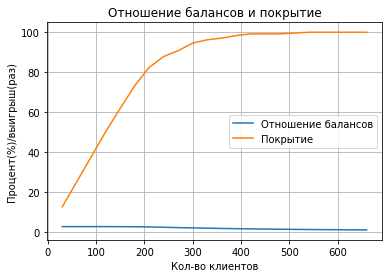

,start_bucket,end_bucket,turget_in_bucket,bucket_bal (%),coverage (%),base_bal (%),bucket_bal/base_bal
0,0,30,30,100.00,12.55,38.36,2.61
1,0,60,60,100.00,25.10,38.36,2.61
2,0,90,90,100.00,37.66,38.36,2.61
3,0,120,120,100.00,50.21,38.36,2.61
4,0,150,148,98.67,61.92,38.36,2.57
5,0,180,175,97.22,73.22,38.36,2.53
6,0,210,197,93.81,82.43,38.36,2.45
7,0,240,210,87.50,87.87,38.36,2.28
8,0,270,217,80.37,90.79,38.36,2.10
9,0,300,226,75.33,94.56,38.36,1.96


In [15]:
# Метрика отношение балансов для трейна

tr_table_cover = final_model.balance_cover(X_train, y_train, min_bin=30, n_obs=650)
tr_table_cover

Всего записей в выборке:  268
Всего таргетов в выборке:  103


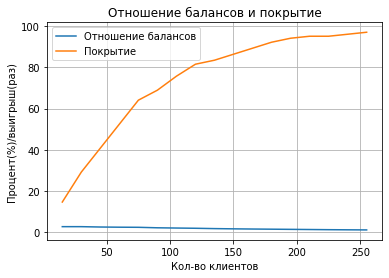

,start_bucket,end_bucket,turget_in_bucket,bucket_bal (%),coverage (%),base_bal (%),bucket_bal/base_bal
0,0,15,15,100.00,14.56,38.43,2.60
1,0,30,30,100.00,29.13,38.43,2.60
2,0,45,42,93.33,40.78,38.43,2.43
3,0,60,54,90.00,52.43,38.43,2.34
4,0,75,66,88.00,64.08,38.43,2.29
5,0,90,71,78.89,68.93,38.43,2.05
6,0,105,78,74.29,75.73,38.43,1.93
7,0,120,84,70.00,81.55,38.43,1.82
8,0,135,86,63.70,83.50,38.43,1.66
9,0,150,89,59.33,86.41,38.43,1.54


In [16]:
# Метрика отношение балансов для валидации

te_table_cover = final_model.balance_cover(X_val, y_val, min_bin=15, n_obs=250)
te_table_cover

## Этап калибровки

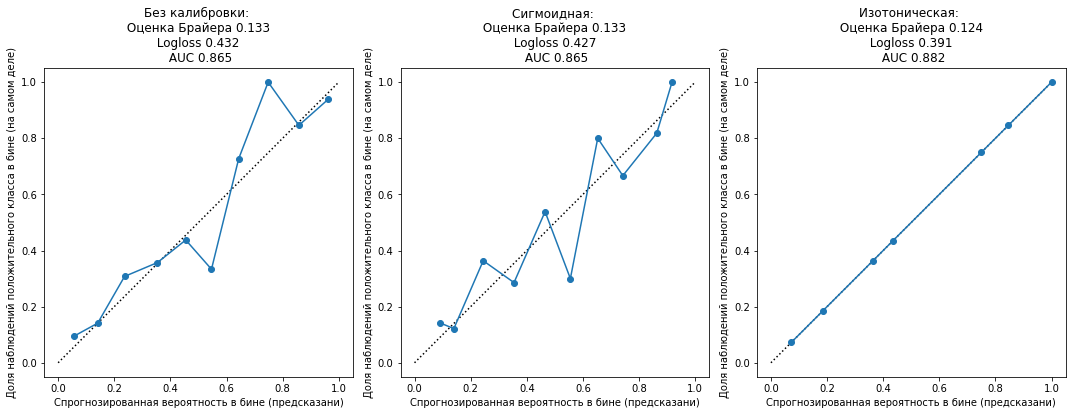

In [17]:
# Калибровка на валидации

final_model.calibration(X_val, y_val, n_bins=10)

### Формирование базового скора, сигмоидной калибровки и изотонической

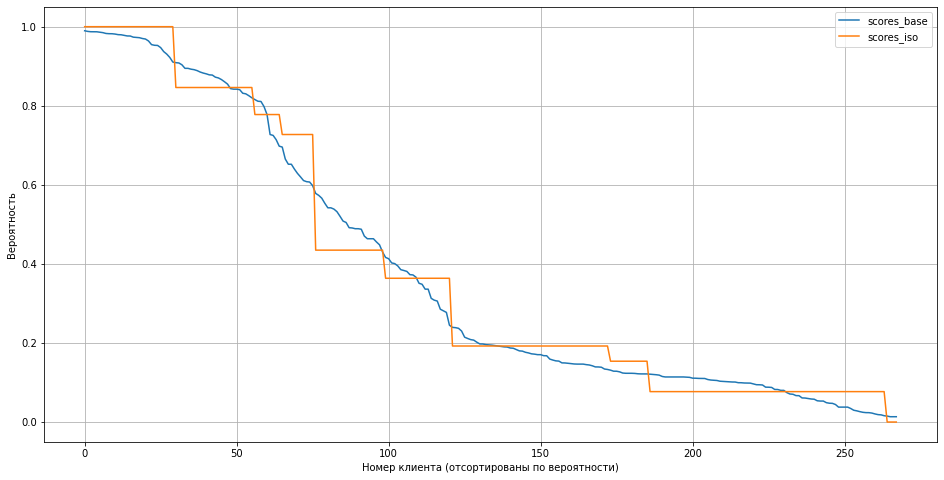

,scores_base,scores_sigm,scores_iso,target
0,0.99,0.92,1.00,1
1,0.99,0.92,1.00,1
2,0.99,0.92,1.00,1
3,0.99,0.92,1.00,1
4,0.99,0.92,1.00,1
...,...,...,...,...
263,0.02,0.08,0.08,1
264,0.02,0.08,0.00,0
265,0.01,0.08,0.00,0
266,0.01,0.08,0.00,0


In [18]:
# Выбор калибровки и сравнение с базовым скором

scores = final_model.calibration_compare(X_val, y_val, calib_compare='scores_iso')
scores

## Сохранение пиклов
Указываем что сохраняем и название папки для создания

* columns - сохранение количественных и категориальных переменных
* prep_pipe - сохранение пайплайна трансформации переменных
* model - сохранение модели
* calibration - сохранение калибровки
* type_calibration - тип сохраняемой калибровки
* path - название генерируемой директории

In [19]:
final_model.get_pickles(
                columns=True,
                prep_pipe=True,
                model=True,
                calibration=True,
                type_calibration='iso',
                path='final_results')

Директория существует


'Все атрибуты сохранены!'